# 해외 축구 선수 이적료 예측 미션  
  
## 모델링

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import GridSearchCV , KFold, train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb
import catboost as cb
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거
pd.set_option('mode.chained_assignment',  None)
from scipy.stats import skew
import scipy.stats as stats

In [2]:
train = pd.read_csv('FIFA_train.csv')
test = pd.read_csv('FIFA_test.csv')
submission = pd.read_csv('submission.csv')

In [3]:
train_copy = train.copy()
test_copy = test.copy()

train_copy.drop(['id','name'],axis=1,inplace=True)
test_copy.drop(['id','name'],axis=1,inplace=True)

In [4]:
contract_train = []
contract_test = []
for i in train_copy['contract_until']:
    contract_train.append(i[-4:])
for i in test_copy['contract_until']:
    contract_test.append(i[-4:])

train_copy['contract_until'] = contract_train
test_copy['contract_until'] = contract_test

# 데이터 형식을 수치형으로 변환
train_copy['contract_until'] = train_copy['contract_until'].astype('int64')
test_copy['contract_until'] = test_copy['contract_until'].astype('int64')

### feature engineering

In [5]:
train_copy['value'] = np.log1p(train_copy['value'])
target = train_copy['value']
train_copy = train_copy.iloc[:,:-1]

* reputation, stat_skill_moves 변수 조작

In [6]:
train_copy['reputation'][train_copy['reputation']>3] = 3
test_copy['reputation'][test_copy['reputation']>3] = 3

train_copy['stat_skill_moves'][train_copy['stat_skill_moves']>4] = 4
test_copy['stat_skill_moves'][test_copy['stat_skill_moves']>4] = 4

---

# 모델링

In [7]:
object_le = LabelEncoder()
train_copy[['continent','position','prefer_foot']] = train_copy[['continent','position','prefer_foot']].apply(object_le.fit_transform)

train_copy = pd.get_dummies(data= train_copy, columns=['continent'], prefix=['continent'])
train_copy = pd.get_dummies(data= train_copy, columns=['position'], prefix=['position'])
train_copy = pd.get_dummies(data= train_copy, columns=['prefer_foot'], prefix=['prefer_foot'])

test_copy[['continent','position','prefer_foot']] = test_copy[['continent','position','prefer_foot']].apply(object_le.fit_transform)
test_copy = pd.get_dummies(data= test_copy, columns=['continent'], prefix=['continent'])
test_copy = pd.get_dummies(data= test_copy, columns=['position'], prefix=['position'])
test_copy = pd.get_dummies(data= test_copy, columns=['prefer_foot'], prefix=['prefer_foot'])

In [8]:
scaler = RobustScaler()
train_copy[['age','stat_overall','stat_potential']] = scaler.fit_transform(train_copy[['age','stat_overall','stat_potential']])
test_copy[['age','stat_overall','stat_potential']] = scaler.transform(test_copy[['age','stat_overall','stat_potential']])

## Stacking

In [9]:
# 메타 모델을 위한 학습 및 테스트 데이터 만들기
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    kf = KFold(n_splits=n_folds, shuffle=True,random_state=42)
    # 빈 배열 생성
    train_fold_pred = np.zeros((X_train_n.shape[0],1))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        print('폴드 세트 : ', folder_counter, ' 시작')
        X_tr = X_train_n.iloc[train_index]
        y_tr = y_train_n.iloc[train_index]
        X_te = X_train_n.iloc[valid_index] 
        
        # 폴드 내 모델 학습
        model.fit(X_tr, y_tr)
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1) # y_train 예측, 폴드 끝나면 concat해야함
        test_pred[:, folder_counter] = model.predict(X_test_n) # y_test 예측, 폴드 끝나면 평균 낼거임
        
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)
    
    return train_fold_pred, test_pred_mean # 하나의 모델에 대한 학습데이터, 테스트 데이터 생성

In [10]:
# 가장 좋은 점수를 받은 모델
# dt,rf 없는 버전
# 객체 생성

ada_reg = AdaBoostRegressor(random_state=42)
gbm_reg = GradientBoostingRegressor(random_state=42)
cat_reg = cb.CatBoostRegressor(random_state=42)
et_reg = ExtraTreesRegressor(random_state=42)
xgb_final = xgb.XGBRegressor(random_state=42)
lgbm_reg = LGBMRegressor(random_state=42)

# 개별 모델로부터 메타 모델에 필요한 데이터 셋 만들기

ada_train, ada_test = get_stacking_base_datasets(ada_reg, train_copy, target, test_copy, 5)
gbm_train, gbm_test = get_stacking_base_datasets(gbm_reg, train_copy, target, test_copy, 5)
cat_train, cat_test = get_stacking_base_datasets(cat_reg, train_copy, target, test_copy, 5)
et_train, et_test = get_stacking_base_datasets(et_reg, train_copy, target, test_copy, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, train_copy, target, test_copy, 5)

# 개별 모델로부터 나온 y_train 예측값들 옆으로 붙이기
Stack_final_X_train = np.concatenate((ada_train,gbm_train,cat_train,et_train,lgbm_train), axis=1)
# 개별 모델로부터 나온 y_test 예측값들 옆으로 붙이기
Stack_final_X_test = np.concatenate((ada_test,gbm_test,cat_test,et_test,lgbm_test), axis=1)

xgb_final.fit(Stack_final_X_train, target)
stack_final = xgb_final.predict(Stack_final_X_test) 

폴드 세트 :  0  시작
폴드 세트 :  1  시작
폴드 세트 :  2  시작
폴드 세트 :  3  시작
폴드 세트 :  4  시작
폴드 세트 :  0  시작
폴드 세트 :  1  시작
폴드 세트 :  2  시작
폴드 세트 :  3  시작
폴드 세트 :  4  시작
폴드 세트 :  0  시작
Learning rate set to 0.055861
0:	learn: 1.3193255	total: 60ms	remaining: 59.9s
1:	learn: 1.2579506	total: 61.5ms	remaining: 30.7s
2:	learn: 1.1997297	total: 63.2ms	remaining: 21s
3:	learn: 1.1439346	total: 64.4ms	remaining: 16s
4:	learn: 1.0897574	total: 65.8ms	remaining: 13.1s
5:	learn: 1.0402114	total: 67.1ms	remaining: 11.1s
6:	learn: 0.9916906	total: 68.5ms	remaining: 9.72s
7:	learn: 0.9458033	total: 70ms	remaining: 8.67s
8:	learn: 0.9021521	total: 71.2ms	remaining: 7.83s
9:	learn: 0.8602506	total: 72.4ms	remaining: 7.17s
10:	learn: 0.8212036	total: 73.8ms	remaining: 6.63s
11:	learn: 0.7836397	total: 74.9ms	remaining: 6.17s
12:	learn: 0.7485140	total: 76.5ms	remaining: 5.8s
13:	learn: 0.7169430	total: 77.5ms	remaining: 5.46s
14:	learn: 0.6858093	total: 78.7ms	remaining: 5.17s
15:	learn: 0.6549053	total: 79.7ms	remaining

In [11]:
np.expm1(stack_final)

array([5.3940308e+07, 1.0331103e+08, 7.8835704e+07, ..., 5.6231070e+04,
       4.9658898e+04, 4.9771457e+04], dtype=float32)

In [18]:
# submission['value'] = np.expm1(stack_final)
# submission.to_csv('stacking last.csv',index=False)

---  
하이퍼 파라미터

In [ ]:
rf_reg = RandomForestRegressor(random_state=42)
param_grid = {'n_estimators':[10,100],
              'max_depth':[4,6,8,10,12],
             'min_samples_leaf':[1,2,4,6,8,12,18],
             'min_samples_split':[2,4,6,8,16,20,24,26]}
grid_rf = GridSearchCV(rf_reg,param_grid = param_grid,cv=5,n_jobs=-1)
grid_rf.fit(train_copy,target)

rf = RandomForestRegressor(random_state=42,**grid_rf.best_params_)
# rf.fit(train_copy,target)

In [ ]:
dt_reg = DecisionTreeRegressor(random_state=42)
param_grid = {'max_depth':[4,6,8,10,12],
             'min_samples_leaf':[6,8,12,18],
             'min_samples_split':[4,6,8,16,20]}
grid_dt = GridSearchCV(dt_reg,param_grid = param_grid,cv=5,n_jobs=-1)
grid_dt.fit(train_copy,target)

dt = DecisionTreeRegressor(random_state=42,**grid_dt.best_params_)
# dt.fit(train_copy,target)

In [ ]:
ada_reg = AdaBoostRegressor(random_state=42)
param_grid = {'n_estimators':[100,150],
              'learning_rate':[0.01,0.1,0.5,1.0]}
grid_ada = GridSearchCV(ada_reg,param_grid = param_grid,cv=5,n_jobs=-1)
grid_ada.fit(train_copy,target)

ada = AdaBoostRegressor(random_state=42,**grid_ada.best_params_)

In [ ]:
gbm_reg = GradientBoostingRegressor(random_state=42)
param_grid = {'n_estimators':[100,150],
              'learning_rate':[0.01,0.1],
             'max_depth':[4,6,8,10,12],
             'min_samples_leaf':[6,8,12,18],
             'min_samples_split':[4,6,8,16,20]}
grid_gbm = GridSearchCV(gbm_reg,param_grid = param_grid,cv=5,n_jobs=-1)
grid_gbm.fit(train_copy,target)

gbm = GradientBoostingRegressor(random_state=42,**grid_gbm.best_params_)

In [ ]:
cat_reg = cb.CatBoostRegressor(random_state=42)
param_grid = {'depth':[2,3,4,5,6,7,8,9,10],
              'learning_rate':[0.01,0.05,0.1,0.2]}
grid_cat = GridSearchCV(cat_reg,param_grid = param_grid,cv=5,n_jobs=-1)
grid_cat.fit(train_copy,target)

cat = cb.CatBoostRegressor(random_state=42,**grid_cat.best_params_)

In [ ]:
# 객체 생성

grid_xgb = GridSearchCV(estimator = xgb.XGBRegressor(learning_rate = 0.1,
                             n_estimators=1000,
                             max_depth=3,
                             min_child_weight=5,
                             gamma=0,
                             reg_alpah=1e-05,
                             subsample=0.71,
                             colsample_bytree=0.6,
                             objective='reg:linear',
                             nthread=-1,
                             scale_pos_weight=1,
                             seed=42),
                       param_grid = [{}], scoring='neg_mean_squared_error')

# 개별 모델로부터 메타 모델에 필요한 데이터 셋 만들기

rf_train, rf_test = get_stacking_base_datasets(rf, train_copy, target, test_copy, 5)
dt_train, dt_test = get_stacking_base_datasets(dt, train_copy, target, test_copy, 5)
ada_train, ada_test = get_stacking_base_datasets(ada, train_copy, target, test_copy, 5)
gbm_train, gbm_test = get_stacking_base_datasets(gbm, train_copy, target, test_copy, 5)
cat_train, cat_test = get_stacking_base_datasets(cat, train_copy, target, test_copy, 5)

# 개별 모델로부터 나온 y_train 예측값들 옆으로 붙이기
Stack_final_X_train = np.concatenate((rf_train,dt_train,ada_train,gbm_train,cat_train), axis=1)
# 개별 모델로부터 나온 y_test 예측값들 옆으로 붙이기
Stack_final_X_test = np.concatenate((rf_test,dt_test,ada_test,gbm_test,cat_test), axis=1)

grid_xgb.fit(Stack_final_X_train, target)
stack_final_hyper = grid_xgb.predict(Stack_final_X_test) 

---

# learning curve

Mean training scores

 1       2.065271e-11
100     5.943243e-06
500     1.076223e-04
2000    1.140072e-03
5000    1.721186e-03
7145    1.910344e-03
dtype: float64

 --------------------

Mean validation scores

 1       23.043815
100     11.836826
500      6.909645
2000     2.690348
5000     0.601019
7145     0.312729
dtype: float64


(0.0, 24.0)

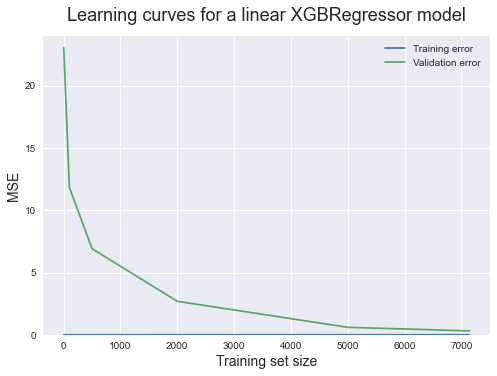

In [19]:
train_sizes = [1,100, 500, 2000, 5000, 7145]

train_sizes, train_scores, validation_scores = learning_curve(
estimator = xgb.XGBRegressor(),
X = train_copy[train_copy.columns],
y = target, train_sizes = train_sizes, cv = 5,
scoring = 'neg_mean_squared_error')

# print('Training scores:\n\n', train_scores)
# print('\n', '-' * 70) # separator to make the output easy to read
# print('\nValidation scores:\n\n', validation_scores)

train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear XGBRegressor model', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0,24)

---
하이퍼 파라미터

Mean training scores

 1       301.344878
100       0.000306
500       0.001326
2000      0.002553
5000      0.003213
7145      0.003485
dtype: float64

 --------------------

Mean validation scores

 1       178.684252
100      11.777511
500       6.790158
2000      2.601594
5000      0.564901
7145      0.286191
dtype: float64


(0.0, 12.0)

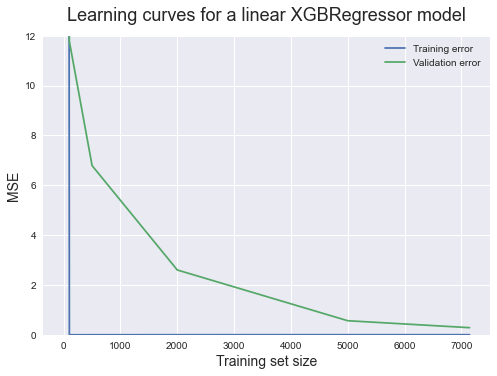

In [20]:
train_sizes = [1,100, 500, 2000, 5000, 7145]

train_sizes, train_scores, validation_scores = learning_curve(
estimator = xgb.XGBRegressor(learning_rate = 0.1,
                             n_estimators=1000,
                             max_depth=3,
                             min_child_weight=5,
                             gamma=0,
                             # reg_alpah=1e-05,
                             subsample=0.71,
                             colsample_bytree=0.6,
                             # objective='reg:linear',
                             nthread=-1,
                             scale_pos_weight=1,
                             seed=42),
X = train_copy[train_copy.columns],
y = target, train_sizes = train_sizes, cv = 5,
scoring = 'neg_mean_squared_error')

# print('Training scores:\n\n', train_scores)
# print('\n', '-' * 70) # separator to make the output easy to read
# print('\nValidation scores:\n\n', validation_scores)

train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear XGBRegressor model', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0,12)